# Day 19 - Kernel Methods

## Kernel Methods
- Uses kernel functions to operate in a higher-dimensional feature space.
- At the core of supervised learning: <b>Support Vector Machines (SVMs)</b>

## Kernel functions

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j)\rangle$

where
- $k$ is the kernel function
- $\vec{x}_i, \vec{x}_j$ are $n$-dimensional input
- $f$ is a map from $n$-demensional space to $m$-dimensional space
- and $\langle ., .\rangle$ denotes the inner product

The kernel function can also be represented by a matrix.

## Quantum Kernels

The main idea is to use quantum feature map to perform the kernel trick, and they can be plugged into classical SVM.
$K_{ij} = |\langle \phi(\vec{x}_i), \phi(\vec{x}_j)\rangle|^2$

where
- $K_{ij}$ is the kernel matrix
- $\vec{x}_i, \vec{x}_j$ are $n$-dimensional input
- $\phi(\vec{x})$ is the quantum feature map
- and $|\langle ., .\rangle|^2$ is the overlap of two quantum states

<!-- Qiskit: QSVC class, PEGASOS QSVC, Quantum Kernel Training -->

In [2]:
!pip install qiskit-algorithms qiskit-machine-learning --quiet

In [8]:
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )

def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

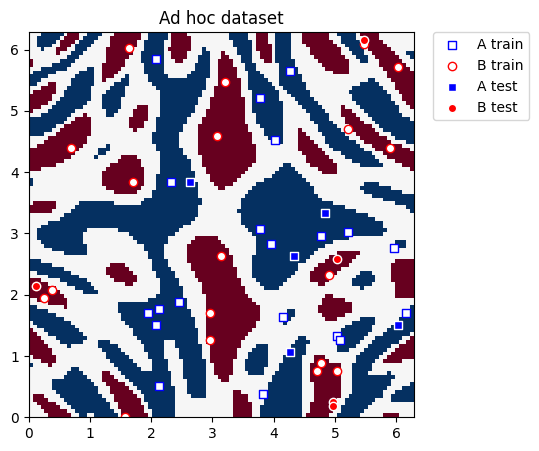

In [10]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

## Quantum Kernel

In [11]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [13]:
print(adhoc_feature_map)

     ┌──────────────────────────┐
q_0: ┤0                         ├
     │  ZZFeatureMap(x[0],x[1]) │
q_1: ┤1                         ├
     └──────────────────────────┘


# QSVM using Pennylane

- Kernel based trainings bypass the processing and measurement parts of variational circuits, and only depends on the data encoding.
- If loss is [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), the kernel method corresponds to standard SVM. Other convex loss functions lead to more general variations of SVMs.

Note:
- Hinge Loss: $l(y) = max(0, 1-t.y)$, where y_true is $t=\pm1$, and y is the raw prediction (not the predicted label).

In [14]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

## Dataset

In [16]:
X, y = load_iris(return_X_y=True)

# iris dataset has 50 samples for each of the 3 classes. pick only the first stwo classes
X = X[:100]
y = y[:100]

# shift y from {0, 1} to {-1, 1}, important for the SVM and the definition of hinge loss
y = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
n_qubits = len(X_train[0])
n_qubits

4

In [18]:
dev = qml.device("lightning.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0][0] = 1

@qml.qnode(dev)
def kernel(x1, x2):
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [22]:
index = 3
kernel(X_train[index], X_train[index])

array(1.)